In [2]:
options(warn=-1)
library("ggplot2")
library("dplyr")
library("reshape2")
library("knitr")
library("ggthemes")
library("psych")
library("car")
library("GGally")
library("gridExtra")
library("RColorBrewer")
library("MASS")
library("Hmisc")
library("ggm")
theme_set(theme_minimal(12))

# 红葡萄酒的探索性数据分析

# 1. 数据简介  

本数据主要包含了红葡萄酒的各项化学数据，并且每瓶红葡萄酒均已由专家打分，具体介绍和下载见下方链接：  

[文档链接](https://s3.amazonaws.com/udacity-hosted-downloads/ud651/wineQualityReds.csv), [文档说明](https://s3.amazonaws.com/udacity-hosted-downloads/ud651/wineQualityInfo.txt)

## 1.1 数据结构：

首先导入数据并查看其数据结构:

In [3]:
redwine <- read.csv("wineQualityReds.csv")
redwine <- subset(redwine,,-X)
names(redwine) <- c("fixed.acidity","volatile.acidity","citric.acid",
                    "residual.sugar","residual.salt","free.SO2",
                    "total.SO2","density","PH","ion.SO42N","alcohol","quality")
set.seed(1880)
testdata <- redwine[sample.int(nrow(redwine),400),]
traindata <- redwine[-sample.int(nrow(redwine),400),]

str(redwine)

'data.frame':	1599 obs. of  12 variables:
 $ fixed.acidity   : num  7.4 7.8 7.8 11.2 7.4 7.4 7.9 7.3 7.8 7.5 ...
 $ volatile.acidity: num  0.7 0.88 0.76 0.28 0.7 0.66 0.6 0.65 0.58 0.5 ...
 $ citric.acid     : num  0 0 0.04 0.56 0 0 0.06 0 0.02 0.36 ...
 $ residual.sugar  : num  1.9 2.6 2.3 1.9 1.9 1.8 1.6 1.2 2 6.1 ...
 $ residual.salt   : num  0.076 0.098 0.092 0.075 0.076 0.075 0.069 0.065 0.073 0.071 ...
 $ free.SO2        : num  11 25 15 17 11 13 15 15 9 17 ...
 $ total.SO2       : num  34 67 54 60 34 40 59 21 18 102 ...
 $ density         : num  0.998 0.997 0.997 0.998 0.998 ...
 $ PH              : num  3.51 3.2 3.26 3.16 3.51 3.51 3.3 3.39 3.36 3.35 ...
 $ ion.SO42N       : num  0.56 0.68 0.65 0.58 0.56 0.56 0.46 0.47 0.57 0.8 ...
 $ alcohol         : num  9.4 9.8 9.8 9.8 9.4 9.4 9.4 10 9.5 10.5 ...
 $ quality         : int  5 5 5 6 5 5 5 7 7 5 ...


> fixed.acidity : 非挥发性酸 单位：$g / dm^3$  
> volatile.acidity: 挥发性酸 单位：$g / dm^3$  
> citric.acid: 柠檬酸 单位：$g / dm^3$  
> residual.sugar: 残留糖分 单位：$g / dm^3$  
> residual.salt: 残留盐分  【原变量名: chlorides】单位：$g / dm^3$  
> free.SO2   : 游离二氧化硫 【原变量名: free sulfur dioxide】 单位：$mg / dm^3$  
> total.SO2     : 二氧化硫总和【原变量名: total sulfur dioxide】 单位：$mg / dm^3$  
> density : 酒的密度 单位：$g / dm^3$  
> PH : 酒的PH值 单位：N/A  
> ion.SO42N : 硫酸盐  【原变量名: sulphates】 单位：$g / dm^3$  
> alcohol : 酒精浓度 单位：% by volume  
> quality : 专家评分 单位：0-10，0最低，10最高  

可以看到完整数据集中有1599条数据，共12个变量，其中quality为因变量，则其余11个变量均可以探索并考虑是否可以做为解释变量进行模型拟合。  

## 1.2 数据探索的主要方向：  
1. 这个数据最引起我注意的就是专家的打分，是什么因素会影响到专家对特定酒的评价？
2. 葡萄酒中的化学成分间彼此之间是何种关系，以及对专家评分的影响有多少？  

PS: 在前期的数据探索阶段都是用`redwine`（1599条）这个完整数据集，在模型拟合阶段将`redwine`根据3：1的比例分成模型训练数据（`traindata`）和模型测试数据（`testdata`）  

# 2. 单变量探索

## 2.1 专家评分(quality)
这里首先查看专家评分的分布来了解其特征：  , args = list(mean = 5.64, sd = 0.81, color="blue")

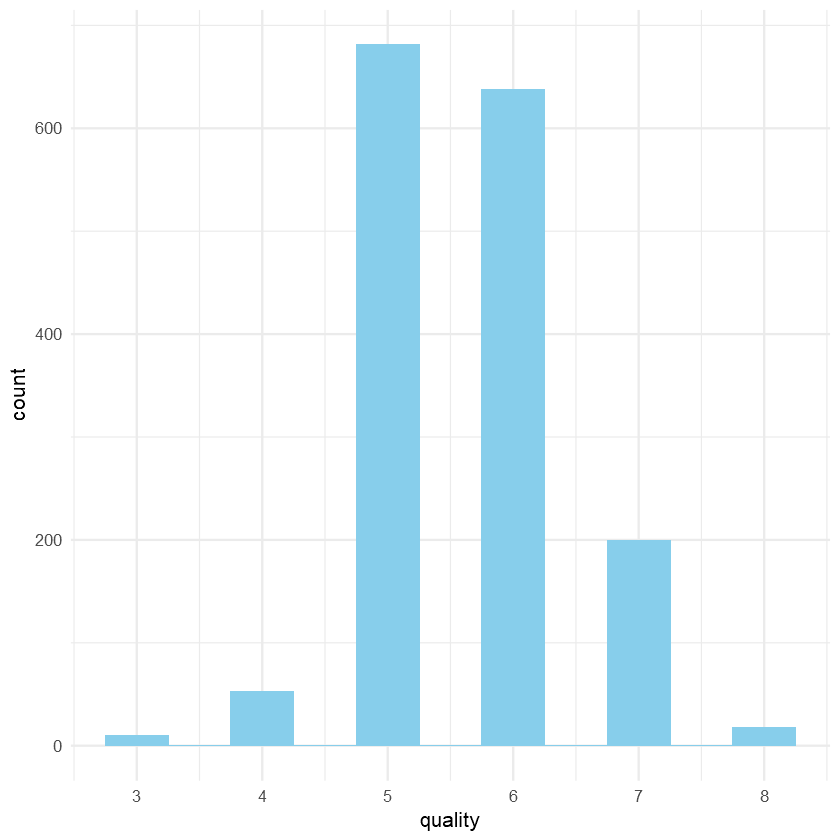

In [4]:
ggplot(redwine,aes(x = quality, fill = factor(quality))) +  #画出quality评分的直方图
  geom_bar(fill = "skyblue",binwidth = 0.5,) + 
  scale_x_continuous(breaks = seq(3,8,1)) 

In [5]:
psych::describe(redwine$quality)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,1599,5.636023,0.8075694,6,5.588603,1.4826,3,8,5,0.2173931,0.2879148,0.02019555


可以看出评分的分布图和正态分布很像, 偏度和峰都都小于$0.3$,非常小,在之后的quality模型拟合中可以假设quality这个因变量服从正态分布。
其次发现，虽然quality这个因素有0 ~ 10十一个评分段位，实际中的分类中只用到了6个，即3，4，5，6，7，8。均值为5.64，标准差为0.81

## 2.2 酒精浓度(alcohol)  

既然是葡萄酒，自然就会对它的酒精浓度有探索的兴趣：

90% 
 12

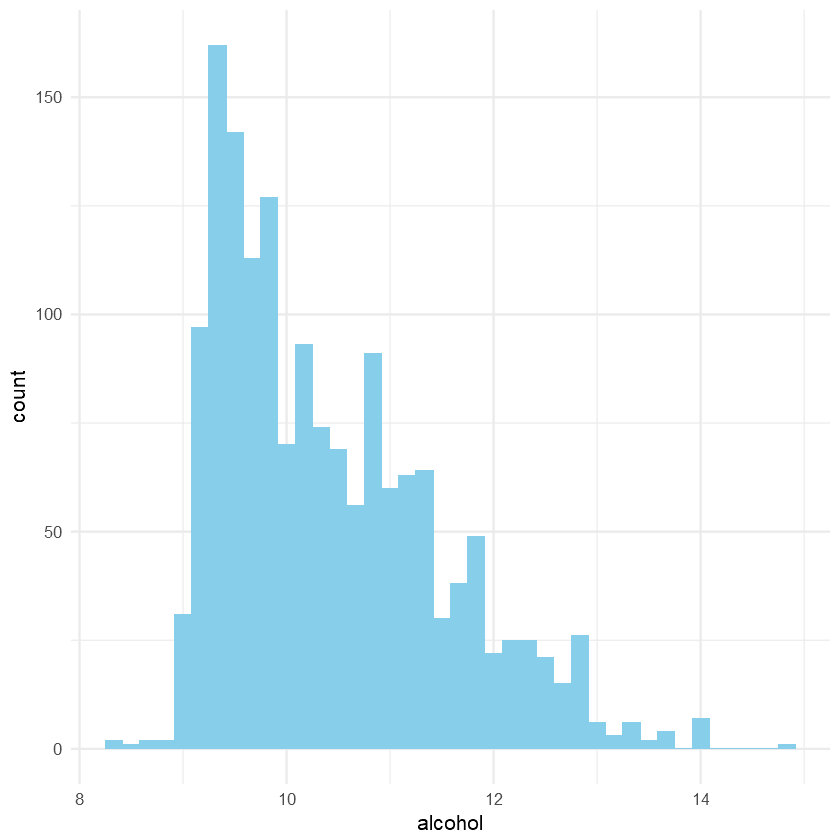

In [6]:
ggplot(redwine,aes(x = alcohol)) +  #画出alcohol的直方图
  geom_histogram(fill = "skyblue",bins = 40) 
with(redwine,quantile(alcohol,probs = 0.9))

alcohol的分布是个典型的右偏分布，葡萄酒的酒精浓度普遍较低,$90\%$酒的酒精浓度都在12°以内。

## 2.3 酸类指标-->非挥发性酸(fixed.acidity),挥发性酸(volatile.acidity),柠檬酸(citric.acid)  

既然葡萄酒是由葡萄所制，必然会带有一定的酸味，分别查看非挥发性酸(fixed.acidity),挥发性酸(volatile.acidity),柠檬酸(citric.acid)的特征：

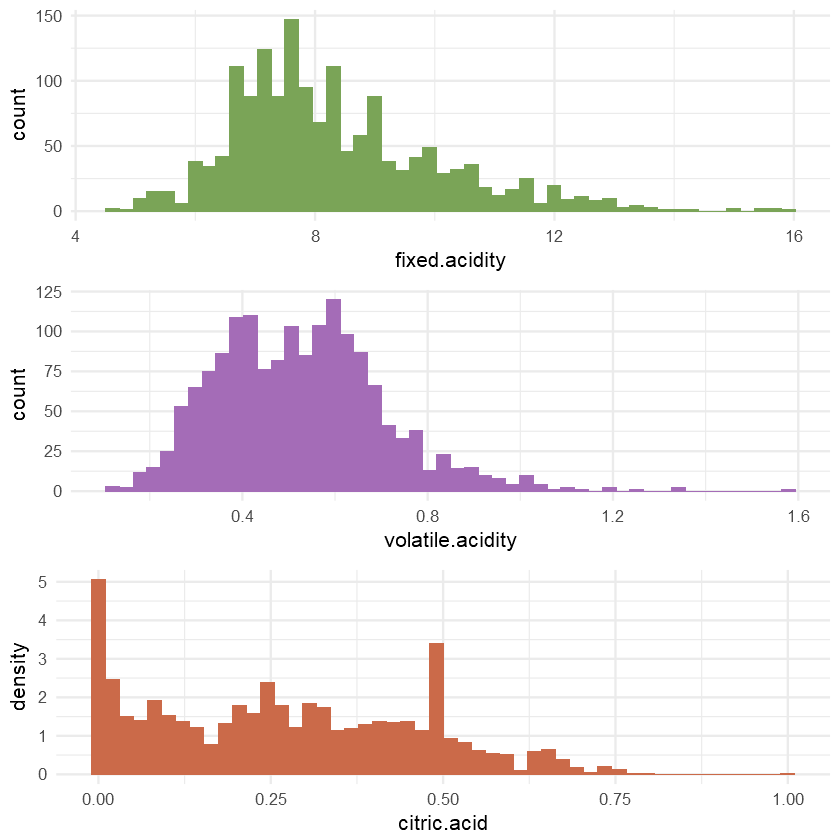

In [14]:
a1 <- ggplot(redwine,aes(x=fixed.acidity)) + 
  geom_histogram(fill = "#7aa457",bins = 50)
a2 <- ggplot(redwine,aes(x=volatile.acidity)) + 
  geom_histogram(fill = "#a46cb7",bins = 50)
a3 <- ggplot(redwine,aes(x=citric.acid,y=..density..)) + 
  geom_histogram(fill = "#cb6a49",bins = 50) 
grid.arrange(a1,a2,a3,ncol =1)

可以初步看出酒中的酸类成分中非挥发性酸(fixed.acidity)和挥发性酸(volatile.acidity)与正态分布很相似。  

而柠檬酸(citric.acid)的分布在大多数情况下分布相对均匀，只有在0和0.5处出现2个非常明显的极值,一个是几乎没有，一个是在整个分布偏右方，造成这种情况的一种猜测是制酒工艺的不同而造成的，只是这个猜想无法通过这个数据集进行验证。  
同时可以发现非挥发性酸(fixed.acidity)和挥发性酸(volatile.acidity)在一个数量级别，而柠檬酸(citric.acid)的量明显少于前两者。

## 2.4 二氧化硫($free.SO_2$,$total.SO_2$)

接下来看下二氧化硫($free.SO_2$,$total.SO_2$)的分布情况：

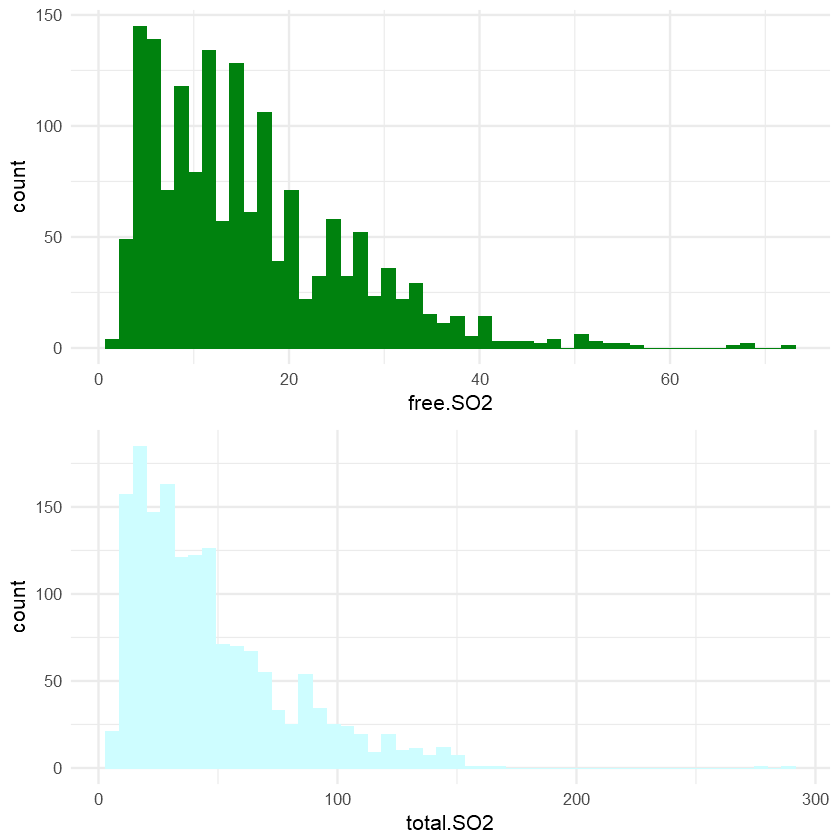

In [15]:
b1 <- ggplot(redwine,aes(x=free.SO2)) + 
  geom_histogram(fill = "#00820e",bins = 50) 
b2 <- ggplot(redwine,aes(x=total.SO2)) + 
  geom_histogram(fill = "#cefdff",bins = 50)

grid.arrange(b1,b2,ncol =1)

无论是游离二氧化硫($free.SO_2$)还是总体二氧化硫($total.SO_2$)是一个右偏分布，这是非常符合常理的，二氧化硫在酒中作为抑菌剂和抗氧化剂，若含量过多则会让饮者可以察觉到二氧化硫特有的气味,而且会对身体有害无益。

## 2.5 剩余元素(PH,density,residual.salt,residual.sugar,$ino.{SO_4}^{2-}$)

最后将剩余的几个元素并列排列进行探索：PH值和酒的密度的分布情况：

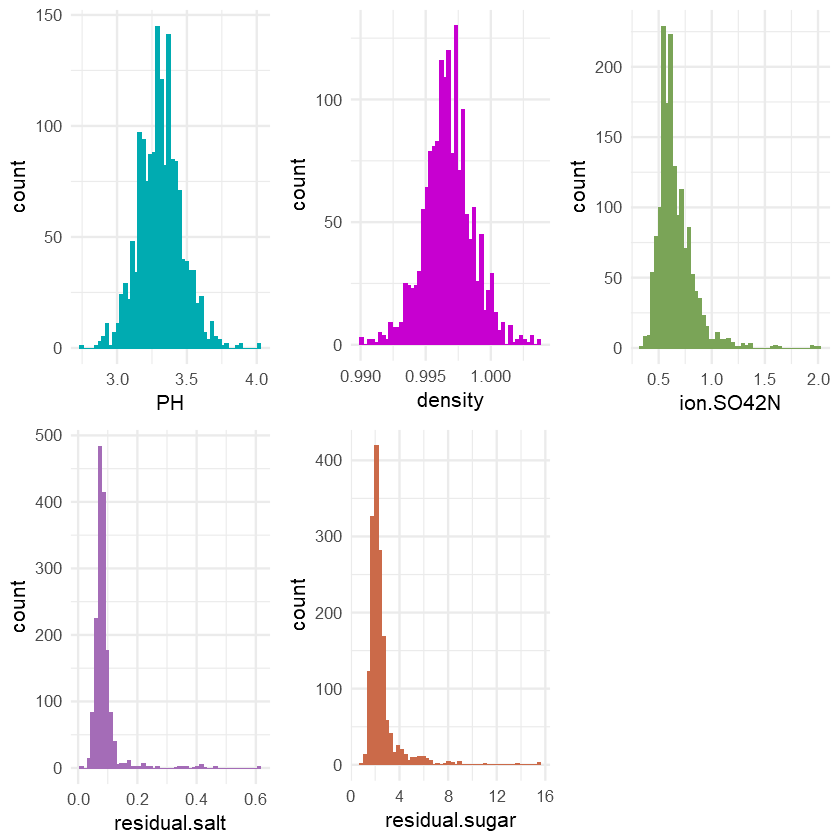

In [16]:
c1 <- ggplot(redwine,aes(x=PH)) + 
  geom_histogram(fill = "#00abb1",bins = 50) 
c2 <- ggplot(redwine,aes(x=density)) + 
  geom_histogram(fill = "#c700d0",bins = 50) 
c3 <- ggplot(redwine,aes(x=ion.SO42N)) + 
  geom_histogram(fill = "#7aa457",bins = 50)
c4 <- ggplot(redwine,aes(x=residual.salt)) + 
  geom_histogram(fill = "#a46cb7",bins = 50)
c5 <- ggplot(redwine,aes(x=residual.sugar)) + 
  geom_histogram(fill = "#cb6a49",bins = 50) 
grid.arrange(c1,c2,c3,c4,c5,ncol=3)

PH值和density的分布是非常接近正态分布的形状，非常漂亮，可以初步知道大部分葡萄酒的PH值介于$[\,3.0\,,\,3.7\,]$之间，其密度小于 $1$，这点应与酒精浓度有关，这可以在之后进步探索。  

对于硫酸盐离子（$ino.{SO_4}^{2-}$），残留的盐（residual.salt）和糖（residual.sugar）在酒中的含量均非常小，而且其分布的峰度很尖，表明数据非常集中，标准差非常小
  
图中可以初步看出，评分越高的红葡萄酒其分布越处于酒精浓度高的部分中，可以进步比较看各箱形图进行分析：

# 3. 双变量分析

## 3.1 alcohol与quality

葡萄酒首先作为酒，初步判断中本人认定酒精浓度应该是影响专家评分的重要因素之一，先查看下在不同得到的酒中，其酒精弄得的分布：


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


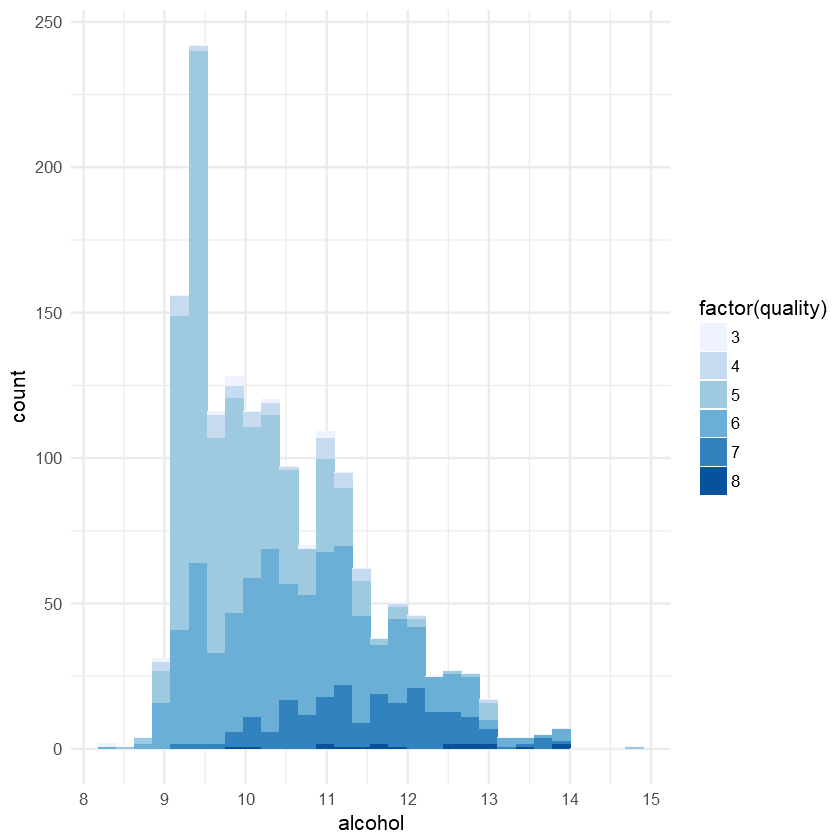

In [18]:
ggplot(redwine,aes(x = alcohol,fill = factor(quality))) +  #画出quality评分的直方图
  geom_histogram() +
  scale_fill_brewer(palette = "Blues") +
  scale_x_continuous(breaks = seq(8,16,1))

从叠加的直方图中我们看到不同专家评分的酒精浓度分布出现的一个向右偏移的趋势，为了进步探索，制作各评分的酒精浓度箱形图查看变化的趋势：  

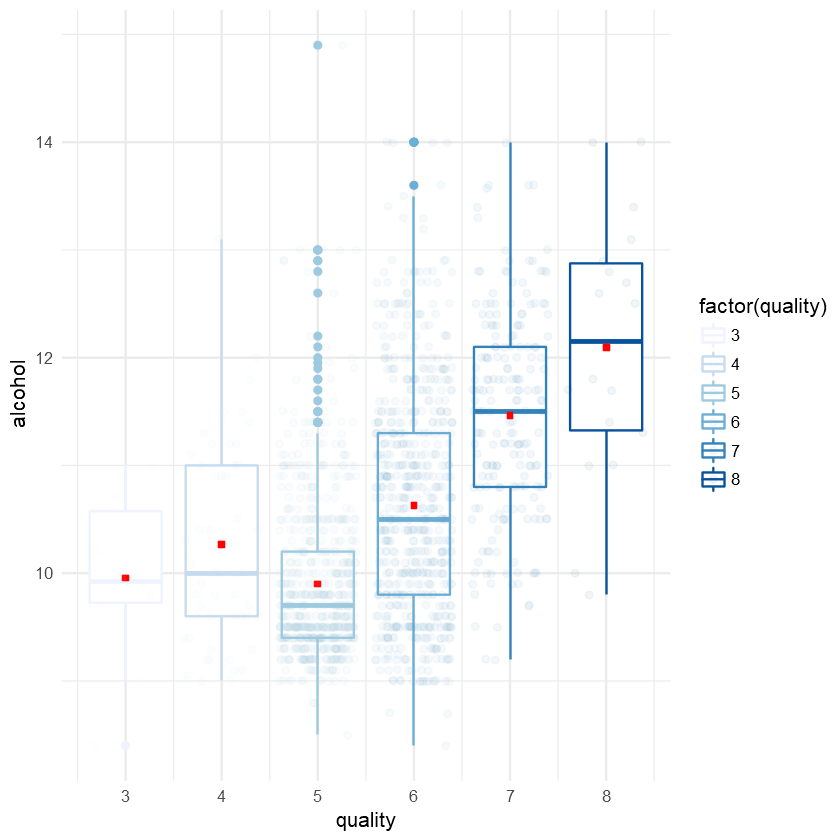

In [19]:
ggplot(redwine, aes(x = quality, y = alcohol,color = factor(quality))) + 
  geom_boxplot() + 
  scale_x_continuous(breaks = seq(3,8,1)) +
  stat_summary(fun.y = mean,geom = "point", shape = 22,
               color = 'red',fill = "red") +
  scale_color_brewer(palette = "Blues") +
  geom_jitter(alpha = .05) 

从图中，我们可以发现随着专家评分的增加，其酒精浓度的分布有望上移的趋势，出现有较为明显的线性变化趋势，从而佐证了我们初期的假定，酒精浓度可以作为影响专家评分的指标之一。

## 3.2 酸类(fixed.acidity, volatile.acidity, citric.acid)与quality  

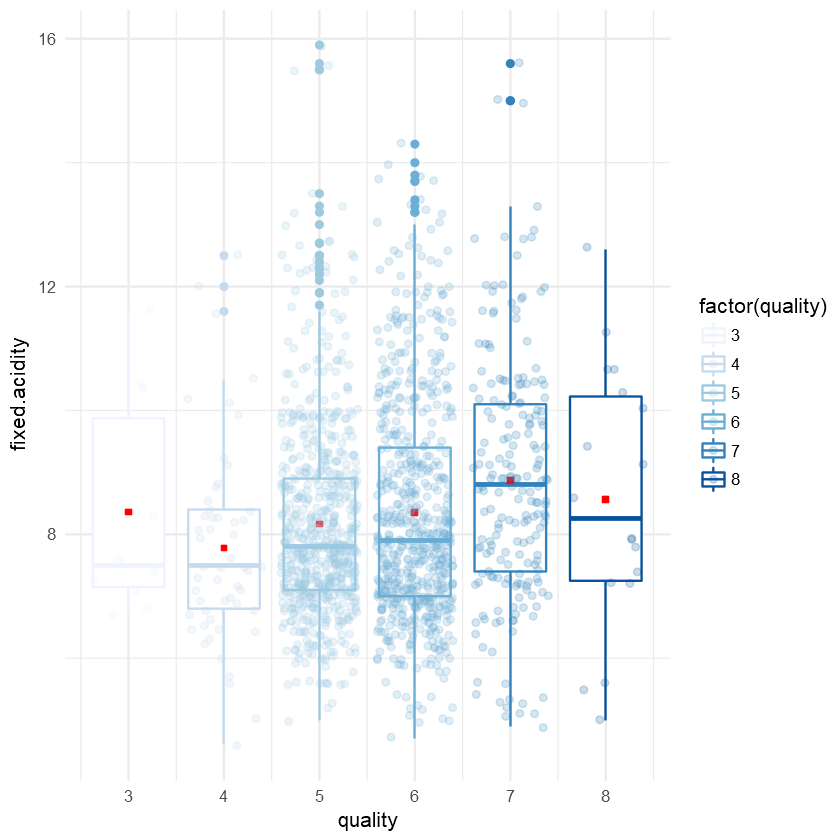

In [20]:
ggplot(redwine, aes(x = quality, y =fixed.acidity,color = factor(quality))) + 
  geom_boxplot() +
  scale_x_continuous(breaks = seq(3,8,1)) +
  stat_summary(fun.y = mean,geom = "point", shape = 22,
               color = 'red',fill = "red") +
  scale_color_brewer(palette = "Blues") +
  geom_jitter(alpha = .2)

非挥发性酸(fixed.acidity)对于专家评分基本没什么影响，各评分之间的fixed.acidity分布基本相同。

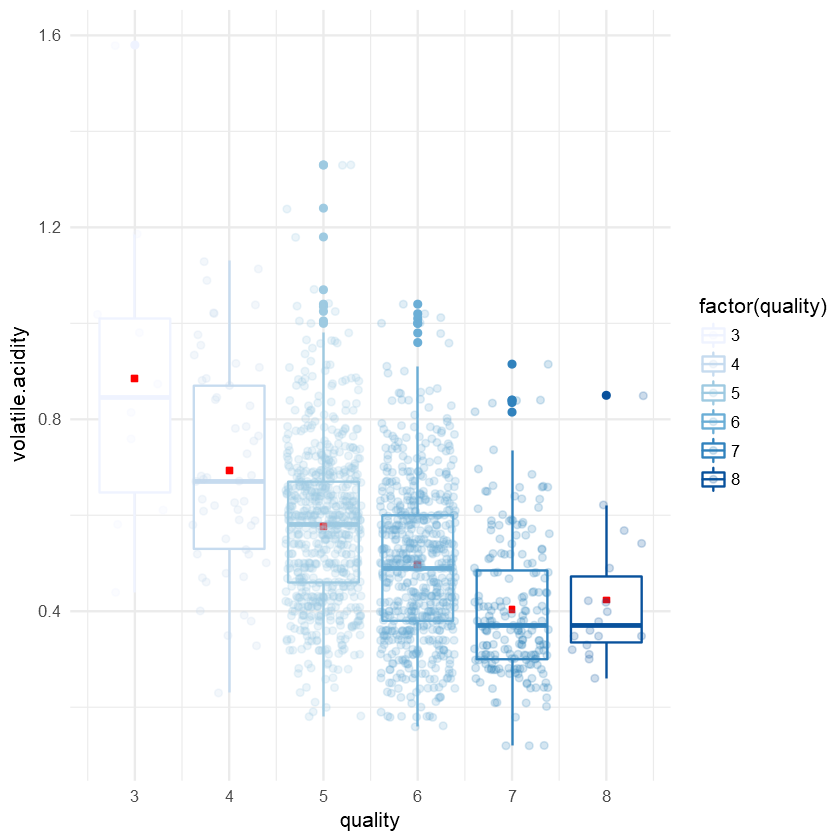

In [21]:
ggplot(redwine, aes(x = quality, y =volatile.acidity,color = factor(quality))) + 
  geom_boxplot() +
  scale_x_continuous(breaks = seq(3,8,1)) +
  stat_summary(fun.y = mean,geom = "point", shape = 22,
               color = 'red',fill = "red") +
  scale_color_brewer(palette = "Blues") +
  geom_jitter(alpha = .2)

挥发性酸(volatile.acidity)与专家评分表现为明显的负线性相关。

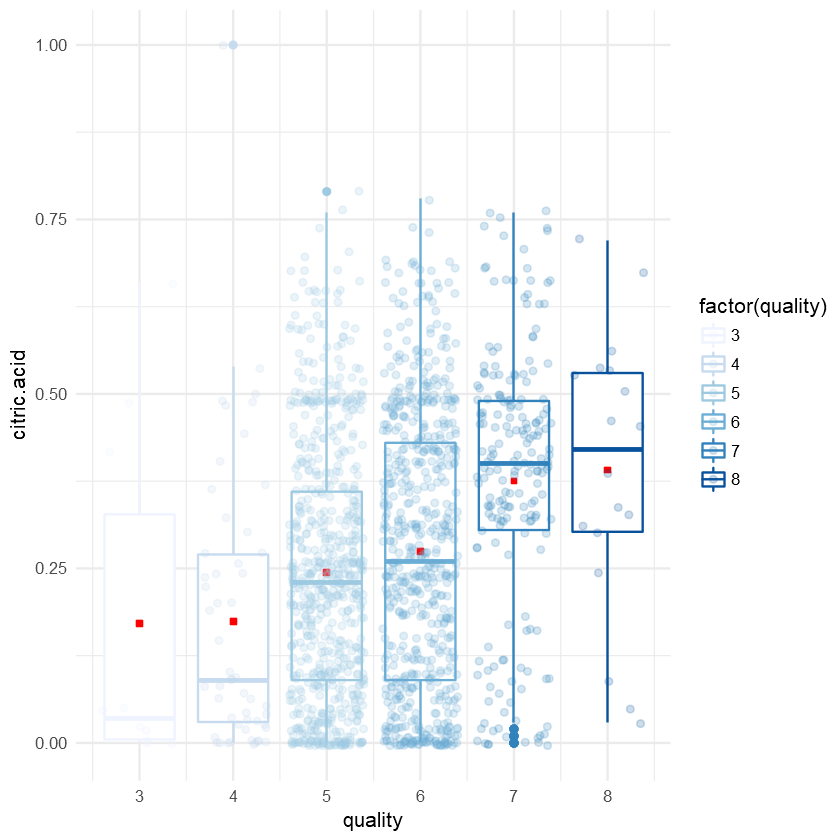

In [22]:
ggplot(redwine, aes(x = quality, y =citric.acid,color = factor(quality))) + 
  geom_boxplot() +
  scale_x_continuous(breaks = seq(3,8,1)) +
  stat_summary(fun.y = mean,geom = "point", shape = 22,
               color = 'red',fill = "red") +
  scale_color_brewer(palette = "Blues") +
  geom_jitter(alpha = .2)

柠檬酸(citric.acid)与专家评分表现为较为明显的正线性相关。  

这两者的表现是一致的，挥发性酸越多，说明酒打开后酸度会下降，从而其与quality的关系和柠檬酸对quality的影响是一致的。  

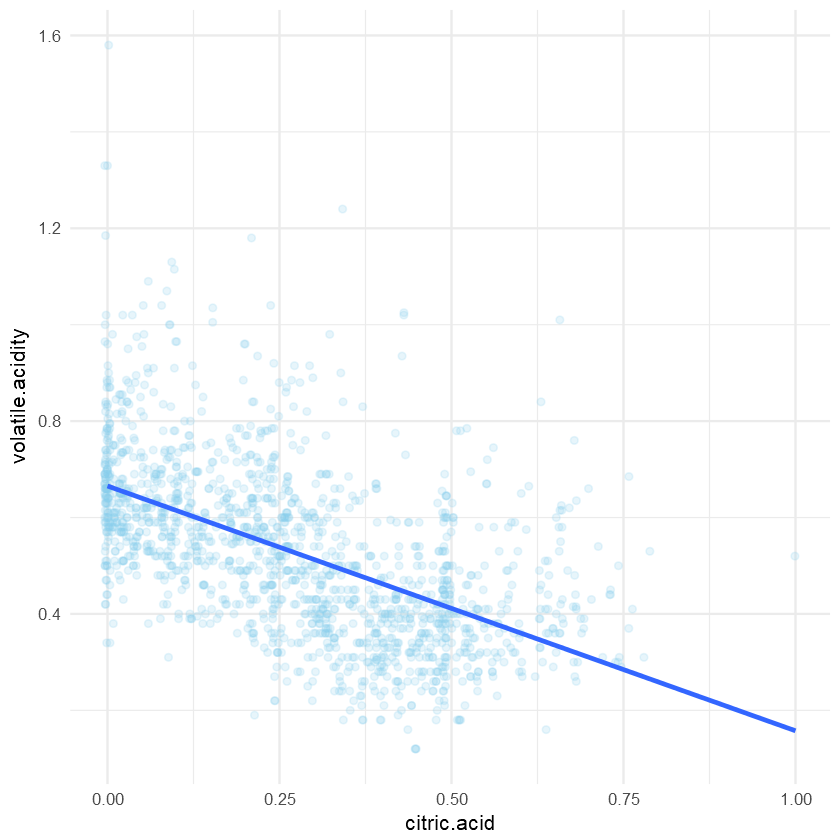

In [23]:
ggplot(redwine,aes(x =citric.acid,y=volatile.acidity)) + 
  geom_point(color = "skyblue",alpha = 1/5,position = position_jitter(h=0)) +
  geom_smooth(method = "lm",se = F)

In [24]:
with(redwine,cor.test(volatile.acidity,citric.acid))


	Pearson's product-moment correlation

data:  volatile.acidity and citric.acid
t = -26.489, df = 1597, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5856550 -0.5174902
sample estimates:
       cor 
-0.5524957 


通过查看volatile.acidity与citric.acid相关系数，我们发现两者处于较强的相关性，在模型的拟合中为避免近似的多重共线性，2者中选择一个既可。  

## 3.3 $ino.{SO_4}^{2-}$与quality

考虑硫酸盐离子（$ino.{SO_4}^{2-}$）对quality的影响：

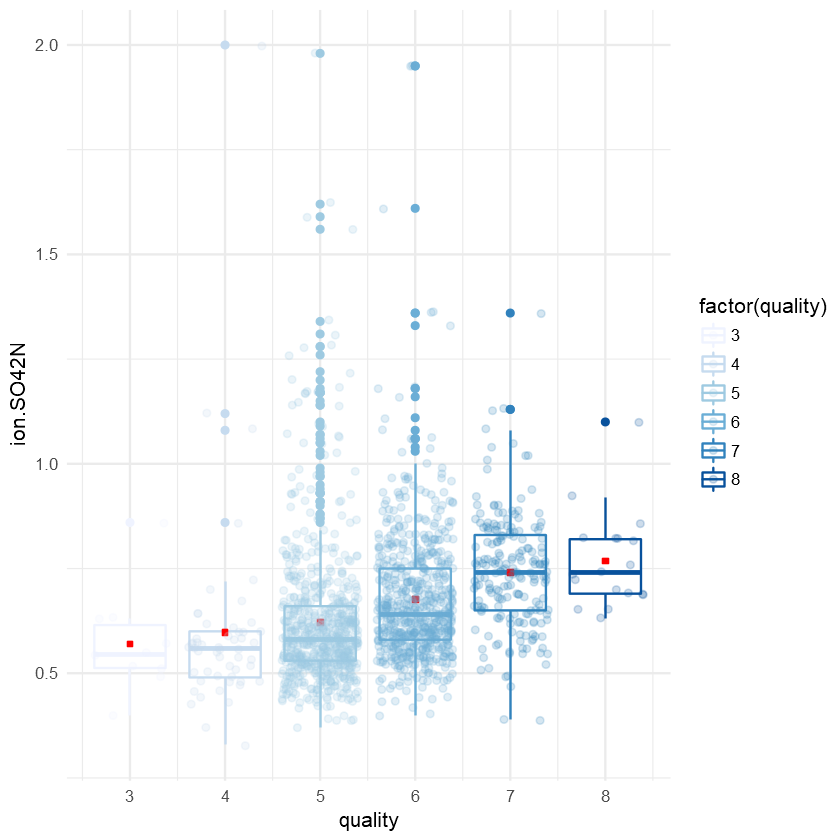

In [25]:
ggplot(redwine, aes(x = quality, y =ion.SO42N,color = factor(quality))) + 
  geom_boxplot() +
  scale_x_continuous(breaks = seq(3,8,1)) +
  stat_summary(fun.y = mean,geom = "point", shape = 22,
               color = 'red',fill = "red") +
  scale_color_brewer(palette = "Blues") +
  geom_jitter(alpha = .2)

看出硫酸盐离子（$ino.{SO_4}^{2-}$）对quality是负向影响，而且也具有一定的线性趋势，也是一个比较合适的解释变量  
## 3.4 residual.salt与quality：

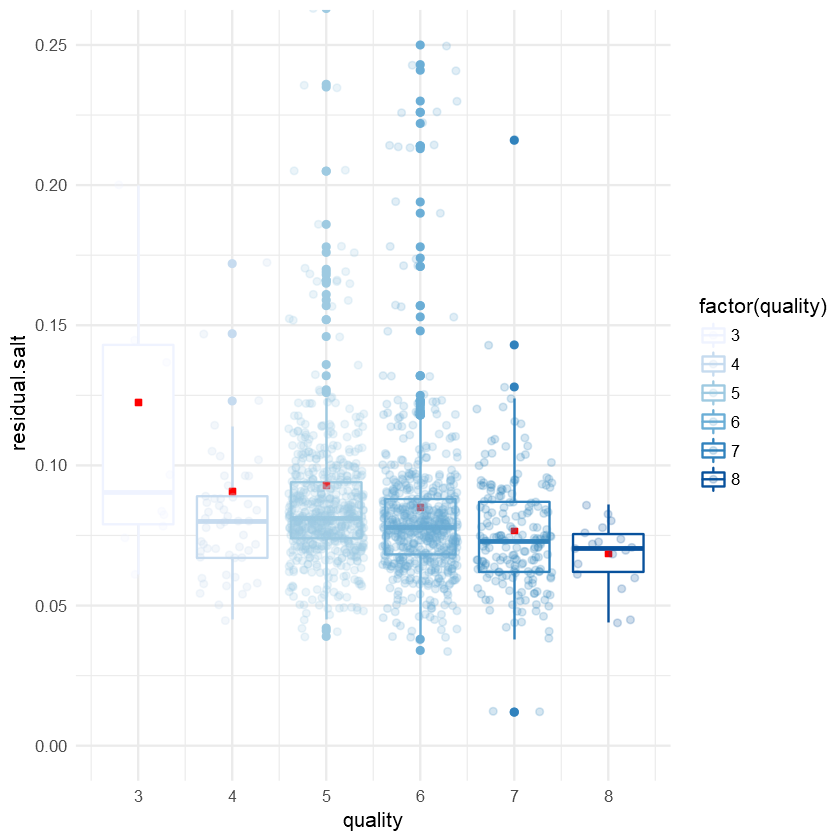

In [26]:
ggplot(redwine, aes(x = quality, y =residual.salt,color = factor(quality))) + 
  geom_boxplot() +
  scale_x_continuous(breaks = seq(3,8,1)) +
  stat_summary(fun.y = mean,geom = "point", shape = 22,
               color = 'red',fill = "red") +
  scale_color_brewer(palette = "Blues") +
  geom_jitter(alpha = .2) +
  coord_cartesian(ylim = c(0,0.25))

从图中我们可以看出residual.salt与quality呈现一定的负相关，是否线性关系需要后续的观察。  

剩余元素用部分因为在酒中的含量非常低，影响不高，还有一部分是和上面已经的探索的因素有很强的相关性（如alcohol与density，酸类与PH等），其对quality的影响都大致相近。

# 4. 多变量分析：

初步的猜测是酒的密度首先和alcohol有关（因为酒精密度小于水），同时其residual。sugar和total.SO2都会影响密度  

## 4.1 density VS alcohol VS residual.sugar  

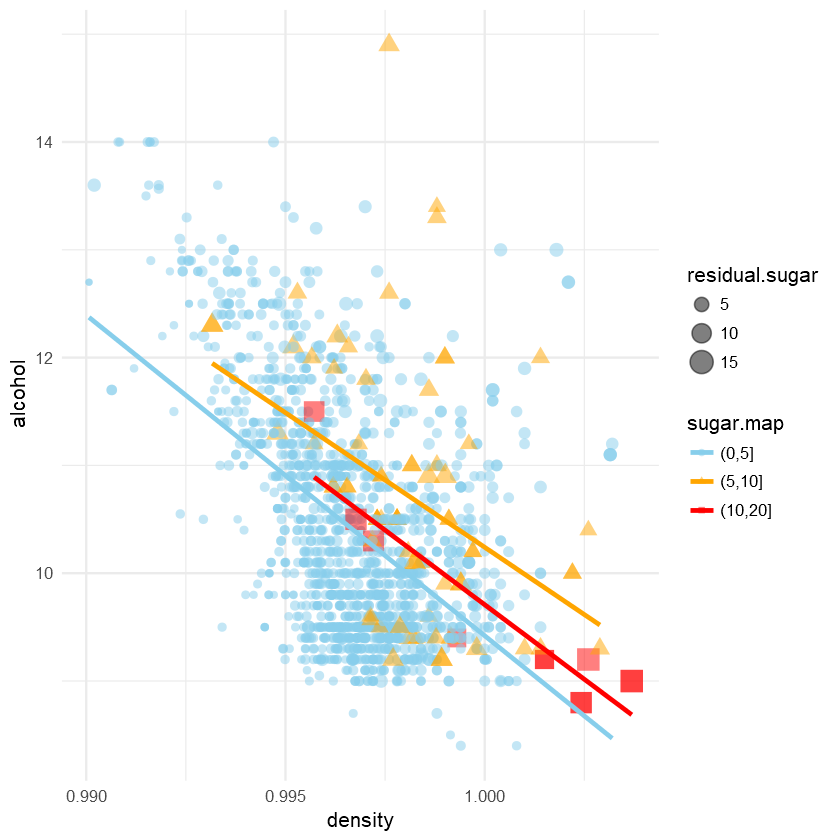

In [27]:
redwine.sugar <- redwine %>% 
  dplyr::select(alcohol,density,residual.sugar,quality) %>% 
  mutate(sugar.map = cut(residual.sugar, breaks = c(0,5,10,20)))

ggplot(redwine.sugar,aes(x = density, y = alcohol, color = sugar.map,
                       shape = sugar.map,size = residual.sugar)) + 
  geom_point(alpha = 0.5) +
  scale_size_area() + 
  geom_smooth(method = "lm", se = FALSE,size=1) +
  scale_color_manual(values = c("skyblue","orange","red")) 

从图中可以看出alcohol和density有很明显的负相关，即酒精浓度越低，则酒的密度越高，这和我们的认识是相符的。  
同时在固定alcohol时，将整个群落可以大致分成三部分，其中代表糖含量在$(\,0\,,\,5\,]$的灰色小球多出现在左侧，而代表糖含量在$(\,5\,,\,10\,]$的橙色三角多出现在中间，而代表糖含量在$(\,10\,,\,15\,]$的红色方块大多出现在右侧（其中间几个异常值主要是因为酒精浓度拉低了密度所致）
含糖量在$(\,5\,,\,10\,]$的点都在$0.993$的右侧，而含糖量在$(\,10\,,\,15\,]$的点走在$0.995$，可以看出随着density的变大，其residual.sugar的含量也在变大，有较大关联。  

## 4.2 density VS alcohol VS total.SO2  

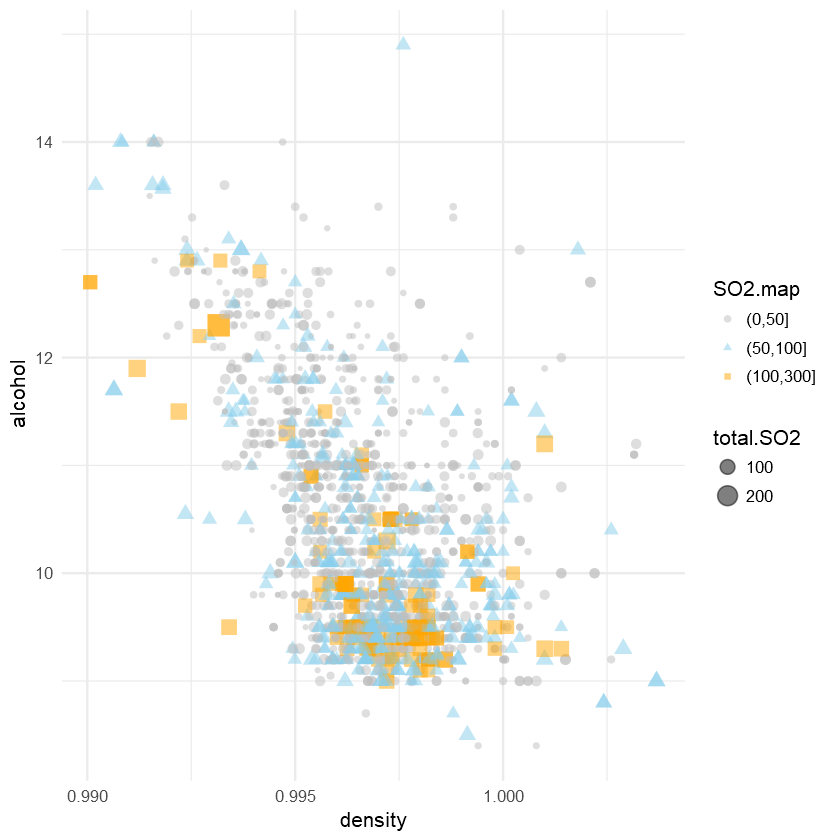

In [28]:
redwine.SO2 <- redwine %>% 
  dplyr::select(alcohol,density,total.SO2,quality) %>% 
  mutate(SO2.map = cut(total.SO2, breaks = c(0,50,100,300)))

ggplot(redwine.SO2,aes(x = density, y = alcohol, color = SO2.map,
                       shape = SO2.map,size =total.SO2)) + 
  geom_point(alpha = 0.5) +
  scale_size_area() +
  scale_color_manual(values = c("grey","skyblue","orange","red")) 

而当看上图中发现total.SO2的分布比较无序，无论是$(\,0\,,\,50\,]$，$(\,50\,,\,100\,]$，还是$(\,100\,,\,300\,]$大部分都集中在密度为$(\,0。998\,,\,1.000\,]$之间，同时在不同高度都有分布，  
因此我们可以判断total.SO2（总体二氧化硫）与density和alcohol并无太大关系。  

因此最后我们得到更正的结论是：酒的密度和酒精浓度，残留的糖含量有较大关联。  


# 5. 模型拟合

## 5.1 模型选择：有序Probit回归模型  

在2.1的分析中已经发现专家评分(quality)非常近似正态分布，同时因为quality为专家主观打分，每个级别的差距均不相同（3-4之间的差距与7-8之间的差距并不相同），同时`redwine`数据集中只有3，4，5，6，7，8六个评分级别，并没有0，1，2，9，10的评分数据，所以这里模型也无法模型出缺失的评分的归类标准。  
有序Probit回归就是假设:  
$$Y^{\ast} = \beta \, \cdot \,X + \xi,\,\,\, \text{其中:} \,\,  \xi \backsim \, N(\,0\,,\,\sigma^2\,),\,\,X = (X_1,X_2,\cdots,X_n)$$
$$Y = \begin{cases}3, & \text{if} \,\,Y^{\ast}<\theta_1 \\
4, & \text{if} \,\,\theta_1\leq Y^{\ast}<\theta_2 \\
5, & \text{if} \,\,\theta_2\leq Y^{\ast}<\theta_3 \\
6, & \text{if} \,\,\theta_3\leq Y^{\ast}<\theta_4 \\
7, & \text{if} \,\,\theta_4\leq Y^{\ast}<\theta_5 \\
8, & \text{if} \,\,Y^{\ast}>\theta_5 \\\end{cases}$$


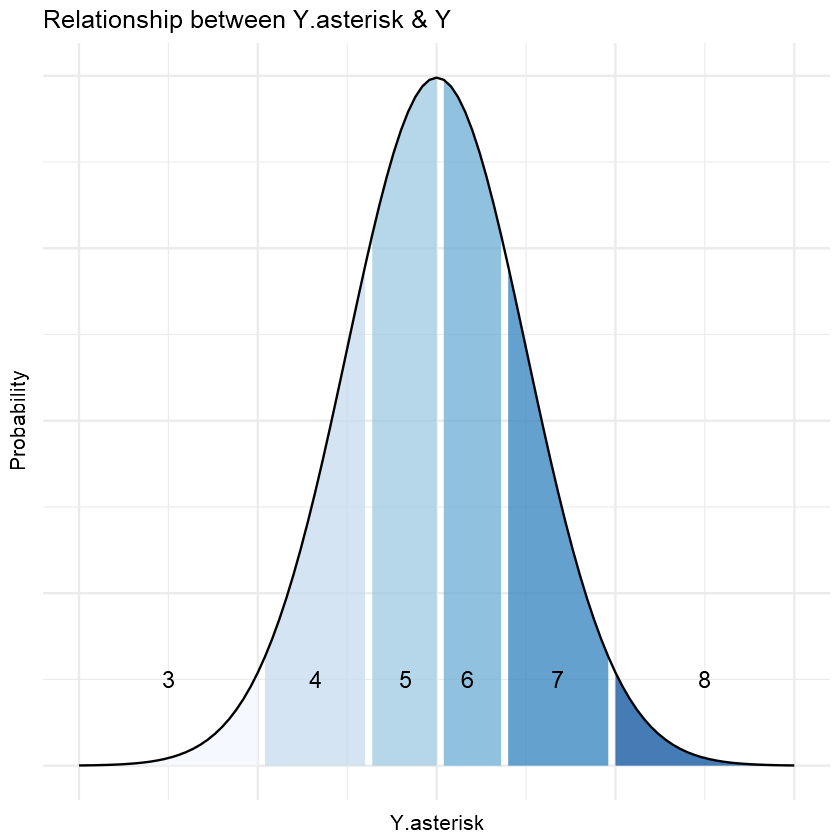

In [31]:
dnorm.3 <- function(x) {y <- dnorm(x,mean = 0,sd = 1)
y[x > -1.96 ] <- NA
return(y)}

dnorm.4 <- function(x) {y <- dnorm(x,mean = 0,sd = 1)
y[x < -1.96 | x > -0.7554 ] <- NA
return(y)}

dnorm.5 <- function(x) {y <- dnorm(x,mean = 0,sd = 1)
y[x < -0.7554 | x > 0.0627 ] <- NA
return(y)}

dnorm.6 <- function(x) {y <- dnorm(x,mean = 0,sd = 1)
y[x < 0.0627 | x > 0.7554 ] <- NA
return(y)}

dnorm.7 <- function(x) {y <- dnorm(x,mean = 0,sd = 1)
y[x < 0.7554 | x > 1.96 ] <- NA
return(y)}

dnorm.8 <- function(x) {y <- dnorm(x,mean = 0,sd = 1)
y[x < 1.96 ] <- NA
return(y)}

y.asterisk = data.frame(seq(-4,4,0.01))
names(y.asterisk) = "Y.asterisk"

y.asterisk$three = pnorm((-1.96-y.asterisk$Y.asterisk),lower.tail = TRUE)
y.asterisk$four = pnorm((-0.7554-y.asterisk$Y.asterisk),lower.tail = TRUE) - 
  pnorm((-1.96-y.asterisk$Y.asterisk),lower.tail = TRUE)
y.asterisk$five = pnorm((0.0627-y.asterisk$Y.asterisk),lower.tail = TRUE) - 
  pnorm((-0.7554-y.asterisk$Y.asterisk),lower.tail = TRUE)
y.asterisk$six = pnorm((0.7554-y.asterisk$Y.asterisk),lower.tail = TRUE) - 
  pnorm((0.0627-y.asterisk$Y.asterisk),lower.tail = TRUE)
y.asterisk$seven = pnorm((1.96-y.asterisk$Y.asterisk),lower.tail = TRUE) - 
  pnorm((0.7554-y.asterisk$Y.asterisk),lower.tail = TRUE)
y.asterisk$eight = 1- pnorm((1.96-y.asterisk$Y.asterisk),lower.tail = TRUE)
names(y.asterisk) <-c("continues_Y","3","4","5","6","7","8")

y.asterisk.long <- melt(data = y.asterisk,id.vars = "continues_Y",
                        variable.name = "category",value.name = "probability")


ggplot(data.frame(x=c(-4, 4)), aes(x=x)) +
  stat_function(fun= dnorm.3, geom="area", fill="#F3F6FF", alpha=0.75) +
  stat_function(fun= dnorm.4, geom="area", fill="#C6DBEF", alpha=0.75) +
  stat_function(fun= dnorm.5, geom="area", fill="#9ECAE1", alpha=0.75) +
  stat_function(fun= dnorm.6, geom="area", fill="#6BAED6", alpha=0.75) +
  stat_function(fun= dnorm.7, geom="area", fill="#3182BD", alpha=0.75) +
  stat_function(fun= dnorm.8, geom="area", fill="#08519C", alpha=0.75) +
  stat_function(fun = dnorm, args = list(mean = 0, sd = 1)) +
  annotate("text", x=-3, y=0.05, label="3",size =5) +
  annotate("text", x=-1.35, y=0.05, label="4",size =5) +
  annotate("text", x=-0.35, y=0.05, label="5",size =5) +  
  annotate("text", x=0.35, y=0.05, label="6",size =5) +
  annotate("text", x=1.35, y=0.05, label="7",size =5) +
  annotate("text", x=3, y=0.05, label="8",size =5) +
  labs(x = "Y.asterisk", y = "Probability",
       title ="Relationship between Y.asterisk & Y") +
  scale_x_continuous(labels = NULL) + 
  scale_y_continuous(labels = NULL)

## 5.2 解释变量选择  

首先解释变量的选择先得观察各变量间的相关程度如何，在这里采用相关系数进行初步观察： 

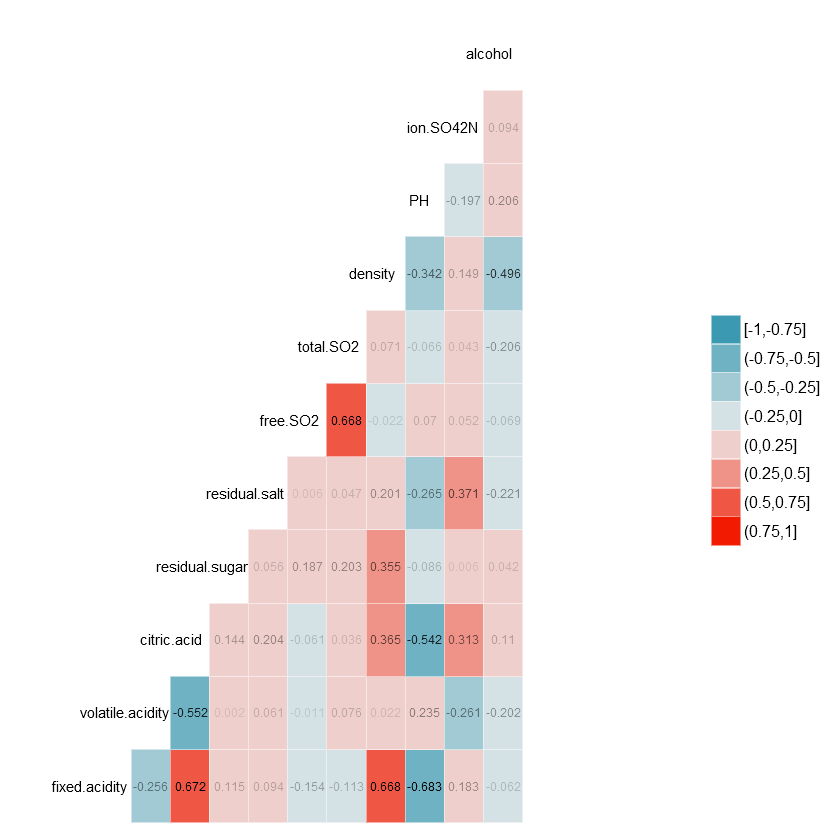

In [32]:
ggcorr(subset(redwine,,-quality),label = TRUE,nbreaks = 8,
       label_size = 2.5,label_round = 3,label_alpha = T,hjust = 0.8,size =3 ) +
  coord_cartesian(xlim = c(-1,15))

density与alcohol有较强的相关性$(-0.496)$  
fixed.acidity与volatile.acidity有较强的相关性$(0.672)$  
citric.acid与volatile.acidity有较强的相关性$(-0.552)$  
free.SO2与total.SO2有较强的相关性$(0.668)$  
PH与酸类元素有高度相关性  
为了拟合的模型具有代表性，需尽量排除具有较强相关性的变量进入模型中，已避免变量中相同的影响进行了重复计量，从而使得模型失真。  
  
这里我们初步选择alcohol, volatile.acidity, ion.SO42N, total.SO2, residual.salt作为模型的解释变量

## 5.3 模型拟合  

首先我们算出各解释变量的偏相关系数，即固定其他解释变量的情况下查看某个解释变量与因变量之间的关系，同时在向模型逐步引入解释变量的时候应按照偏相关系数从大到小依次引入，若在引入第t个解释变量后发现其不具有显著性，则没有必要再将后续解释变量引入到模型中。

In [33]:
quality <- pcor(c(12,11,1:10),var(redwine)) #quality和alcohol偏相关系数
quality[2] <-pcor(c(12,2,1,3:11),var(redwine)) #quality和volatile.acidity偏相关系数
quality[3] <-pcor(c(12,10,1:9,11),var(redwine)) #quality和ion.SO42N偏相关系数
quality[4] <-pcor(c(12,7,1:6,8:11),var(redwine)) #quality和total.SO2偏相关系数
quality[5] <-pcor(c(12,5,1:4,6:11),var(redwine)) #quality和residual.salt偏相关系数
quality[6] <-pcor(c(12,9,1:8,10:11),var(redwine)) #quality和PH偏相关系数
quality[7] <-pcor(c(12,6,1:5,7:11),var(redwine)) #quality和free.SO2偏相关系数
quality[8] <-pcor(c(12,3,1:2,4:11),var(redwine)) #quality和citric.acid偏相关系数
quality[9] <-pcor(c(12,4,1:3,5:11),var(redwine)) #quality和residual.sugar偏相关系数
quality[10] <-pcor(c(12,1,2:11),var(redwine)) #quality和fixed.acidity偏相关系数
quality[11] <-pcor(c(12,8,1:7,9:11),var(redwine)) #quality和density偏相关系数
pcorrelation <- c("alcohol","volatile.acidity","ion.SO42N",
                  "total.SO2","residual.salt","PH","free.SO2",
                  "citric.acid","residual.sugar","fixed.acidity","density")
wd = data.frame(pcorrelation,quality,stringsAsFactors = FALSE)
print(wd)

       pcorrelation     quality
1           alcohol  0.25325645
2  volatile.acidity -0.21914942
3         ion.SO42N  0.19722492
4         total.SO2 -0.11174916
5     residual.salt -0.11150873
6                PH -0.05411548
7          free.SO2  0.05035716
8       citric.acid -0.03112279
9    residual.sugar  0.02731602
10    fixed.acidity  0.02416842
11          density -0.02074412


根据上表的偏相关系数每次引入一个解释变量。这里模型拟合所用的是`traindata`（为`redwine`的$75\%$）

In [34]:
m0 <- polr(as.ordered(quality) ~ 1,data = traindata, method = "probit",Hess = TRUE)
m1 <- update(m0, ~ . + alcohol)
m2 <- update(m1, ~ . + volatile.acidity)
m3 <- update(m2, ~ . + ion.SO42N)
m4 <- update(m3, ~ . + total.SO2)
m5 <- update(m3, ~ . + residual.salt)
anova(m0,m1,m2,m3,m4,m5)
Anova(m4,type = "III")
summary(m4)

Model,Resid. df,Resid. Dev,Test,Df,LR stat.,Pr(Chi)
1,1194,2849.145,,NA,NA,NA
alcohol,1193,2541.455,1 vs 2,1,307.689893,0.000000e+00
alcohol + volatile.acidity,1192,2392.335,2 vs 3,1,149.120242,0.000000e+00
alcohol + volatile.acidity + ion.SO42N,1191,2355.436,3 vs 4,1,36.899571,1.243733e-09
alcohol + volatile.acidity + ion.SO42N + total.SO2,1190,2331.771,4 vs 5,1,23.664685,1.146675e-06
alcohol + volatile.acidity + ion.SO42N + residual.salt,1190,2340.897,5 vs 6,0,-9.126506,1.000000e+00


,LR Chisq,Df,Pr(>Chisq)
alcohol,213.17302,1,2.790141e-48
volatile.acidity,78.54715,1,7.811159e-19
ion.SO42N,32.92052,1,9.600476e-09
total.SO2,12.52817,1,4.008624e-04


Call:
polr(formula = as.ordered(quality) ~ alcohol + volatile.acidity + 
    ion.SO42N + total.SO2, data = traindata, Hess = TRUE, method = "probit")

Coefficients:
                    Value Std. Error t value
alcohol           0.49722   0.033767  14.725
volatile.acidity -2.03475   0.196622 -10.349
ion.SO42N         1.32174   0.203067   6.509
total.SO2        -0.00511   0.001054  -4.851

Intercepts:
    Value    Std. Error t value 
3|4   1.7760   0.4256     4.1727
4|5   2.5476   0.4060     6.2753
5|6   4.5716   0.4063    11.2505
6|7   6.1989   0.4249    14.5875
7|8   7.6982   0.4520    17.0301

Residual Deviance: 2331.771 
AIC: 2349.771 

可以看到当引入第4个解释变量：total.SO2时我们发现虽然该变量通过了显著性测试，通过是其$\beta = -0.005$，对quality的影响非常微小，所以在这里不添加进模型，继续考虑将residual.salt加入进模型：


In [35]:
summary(m5)
Anova(m5,type = "III")

Call:
polr(formula = as.ordered(quality) ~ alcohol + volatile.acidity + 
    ion.SO42N + residual.salt, data = traindata, Hess = TRUE, 
    method = "probit")

Coefficients:
                   Value Std. Error t value
alcohol           0.4955    0.03402  14.565
volatile.acidity -1.9745    0.19796  -9.974
ion.SO42N         1.5932    0.22380   7.119
residual.salt    -3.0538    0.80325  -3.802

Intercepts:
    Value   Std. Error t value
3|4  1.9074  0.4255     4.4830
4|5  2.7165  0.4023     6.7521
5|6  4.7310  0.4028    11.7456
6|7  6.3443  0.4220    15.0350
7|8  7.8519  0.4497    17.4617

Residual Deviance: 2340.897 
AIC: 2358.897 

,LR Chisq,Df,Pr(>Chisq)
alcohol,223.945752,1,1.246661e-50
volatile.acidity,81.143851,1,2.098710e-19
ion.SO42N,44.121531,1,3.086077e-11
residual.salt,3.401663,1,6.513074e-02


这里residual.salt并未通过显著性测试，所以之后的变量也没有必要继续引入，综上可以选择m3（3个解释变量）模型最为合适：

In [36]:
Anova(m3,type = "III")
summary(m3)
m3data <- data.frame(m3$lp,m3$fitted.values)
names(m3data) <- c("quality_ima","3","4","5","6","7","8")
m3data_long <- melt(m3data,id.vars = c("quality_ima"),
                    variable.name = "category",value.name = "prob")

,LR Chisq,Df,Pr(>Chisq)
alcohol,254.48930,1,2.727510e-57
volatile.acidity,87.60793,1,7.980400e-21
ion.SO42N,29.98592,1,4.351945e-08


Call:
polr(formula = as.ordered(quality) ~ alcohol + volatile.acidity + 
    ion.SO42N, data = traindata, Hess = TRUE, method = "probit")

Coefficients:
                   Value Std. Error t value
alcohol           0.5209    0.03334  15.625
volatile.acidity -2.0654    0.19618 -10.528
ion.SO42N         1.2236    0.20129   6.079

Intercepts:
    Value    Std. Error t value 
3|4   2.1740   0.4184     5.1958
4|5   2.9732   0.3959     7.5093
5|6   4.9743   0.3972    12.5221
6|7   6.5754   0.4169    15.7705
7|8   8.0676   0.4450    18.1301

Residual Deviance: 2355.436 
AIC: 2371.436 

其模型的数学表达式：  
$$Y^{\ast} = 0.5209 \cdot alcohol - 2.0654 \cdot volatile.acidity + 1.2236 \cdot ion.SO42N + \xi,\,\,\, \text{其中:} \,\,  \xi \backsim \, N(\,0\,,\,0.64\,)$$
$$Y = \begin{cases}3, & \text{if} \,\, Y^{\ast}<2.1740 \\
4, & \text{if} \,\,2.1740\leq Y^{\ast}<2.9732 \\
5, & \text{if} \,\,2.9732\leq Y^{\ast}<4.9743 \\
6, & \text{if} \,\,4.9743\leq Y^{\ast}<6.5754 \\
7, & \text{if} \,\,6.5754\leq Y^{\ast}<8.0676 \\
8, & \text{if} \,\,Y^{\ast}>8.0676 \\\end{cases}$$
  
模型说明：  

- 酒精浓度每提高一度，会使$Y^{\ast}$增加0.5209
- 挥发性酸每提高一单位，会使$Y^{\ast}$减少2.0654
- 硝酸盐离子每提高一单位，使$Y^{\ast}$增加1.2236
  


## 5.4 模型测试

这里使用`testdata`（为`redwine`数据的$25\%$）来测试5.3得到的模型的拟合表现：

Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"

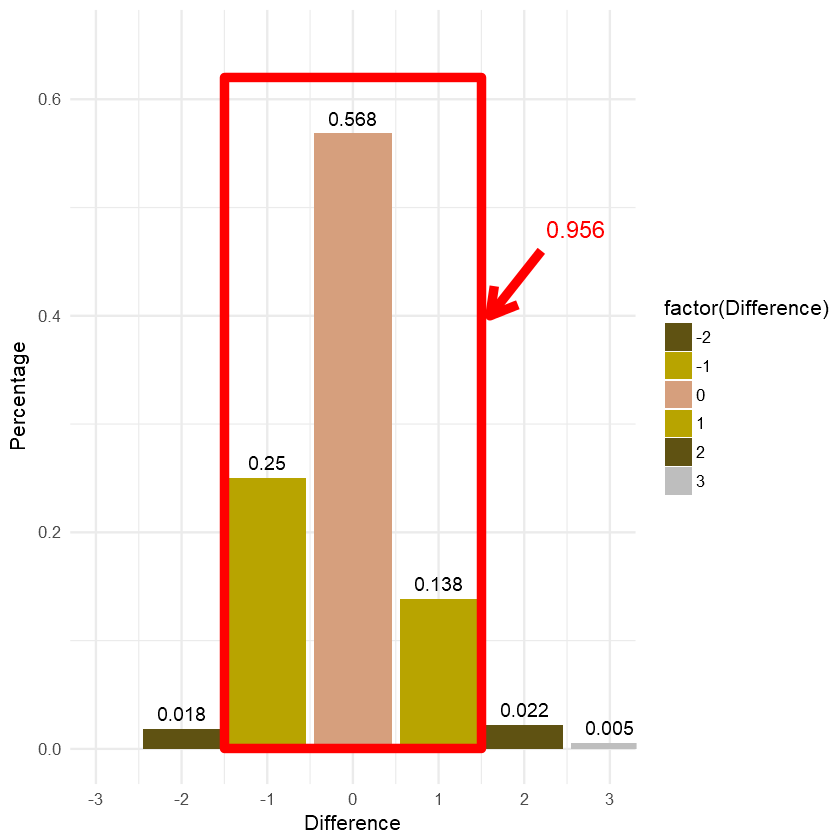

In [37]:
testdata$predict.hat <- predict(m3,newdata = subset(testdata,,c(alcohol,volatile.acidity,ion.SO42N)))

testdata$predict.hat <- as.integer(levels(testdata$predict.hat))[testdata$predict.hat]
accuracy <- as.data.frame(with(testdata,
                               table(predict.hat-quality )/nrow(testdata)),stringsAsFactors = F)
names(accuracy) <- c("Difference","Percentage")
accuracy$Difference <- as.integer(accuracy$Difference)
accuracy$Percentage <- round(accuracy$Percentage,3)

ggplot(accuracy,aes(x = Difference, y = Percentage,fill = factor(Difference),label = Percentage)) +
  geom_histogram(stat = "identity") +
  coord_cartesian(xlim = c(-3,3),ylim = c(0,0.65)) +
  scale_x_continuous(breaks = seq(-3,3,1)) +
  scale_fill_manual(values = c("-2" = "#5f5212","2" = "#5f5212",
                               "-1"="#b8a400","1" = "#b8a400",
                               "0" = "#d69f7d","3" = "grey","-3" = "grey")) +
  geom_text(vjust =-0.6) +
  annotate("rect", xmin=-1.5, xmax=1.5, ymin=0, ymax=0.62, 
           alpha=0,color="red",fill ="white",size =2) +
  annotate("segment", x=2.2, xend=1.6, y=0.46, yend=0.4, 
           colour="red",size=2, arrow=arrow()) +
  annotate("text", x=2.6, y=0.48, label="0.956",size =5,color="red") 

从图中$Difference = \hat{quality} - quality$。完全吻合的概率是$56.8\%$，差距在一个级别之内的概率为$95.6\%$，模型的表现良好。

# 6. 三部图汇总  



## 6.1 图1


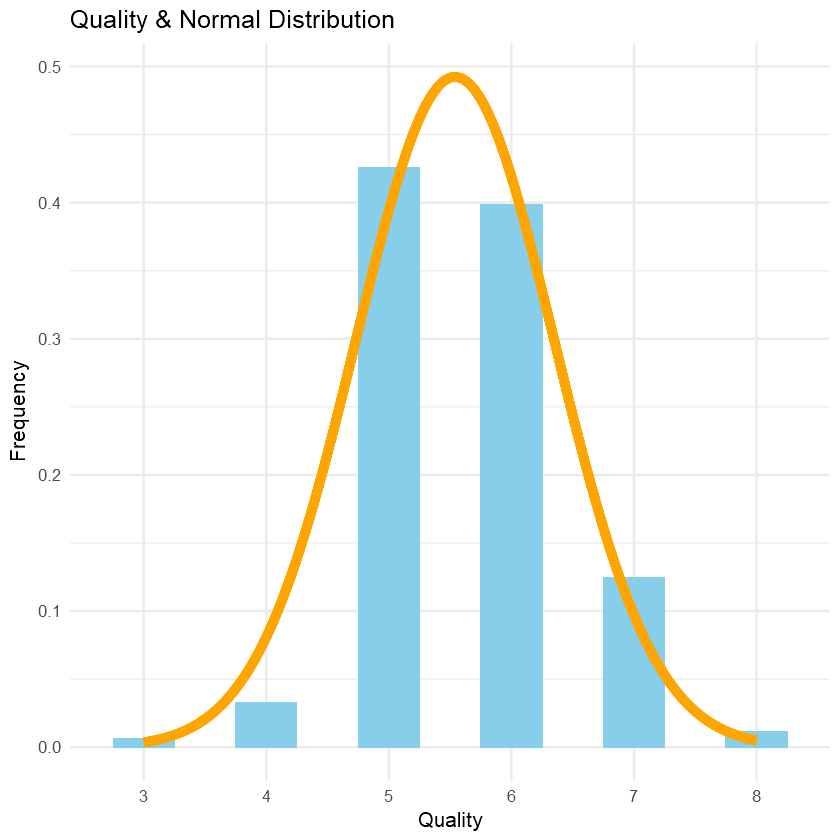

In [38]:
count <- as.data.frame(round(with(redwine,
                               table(quality))/1599,4),stringsAsFactors = F)

ggplot(count, aes(x = quality, y = Freq)) +
  geom_bar(stat="identity",width = 0.5,fill="skyblue") +
  stat_function(fun = dnorm, 
                args = list(mean = 3.54, sd = 0.81), 
                lwd = 2, 
                col = 'orange') +
  labs(title = "Quality & Normal Distribution",x = "Quality",
       y = "Frequency")

最重要的一张就是quality的分布图，从中发现quality的分布非常近似正态分布，同时有因为quality是有序变量，所以在模型的选择上确定为有序Probit模型。  

## 6.2 图2  


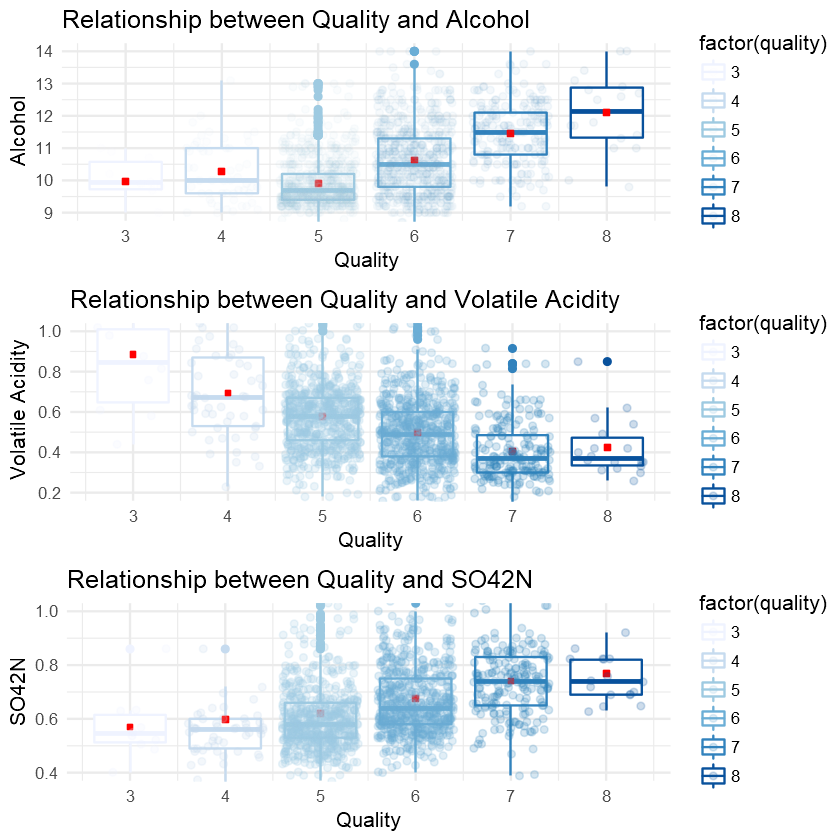

In [39]:
t1 <- ggplot(redwine, aes(x = quality, y = alcohol,color = factor(quality))) + 
  geom_boxplot() + 
  scale_x_continuous(breaks = seq(3,8,1)) +
  stat_summary(fun.y = mean,geom = "point", shape = 22,
               color = 'red',fill = "red") +
  scale_color_brewer(palette = "Blues") +
  geom_jitter(alpha = .05) +
  labs(title = "Relationship between Quality and Alcohol",
       x = "Quality",y="Alcohol") +
  coord_cartesian(ylim = c(9,14),)

t2 <- ggplot(redwine, aes(x = quality, y =volatile.acidity,color = factor(quality))) + 
  geom_boxplot() +
  scale_x_continuous(breaks = seq(3,8,1)) +
  stat_summary(fun.y = mean,geom = "point", shape = 22,
               color = 'red',fill = "red") +
  scale_color_brewer(palette = "Blues") +
  geom_jitter(alpha = .2) +
  labs(title = "Relationship between Quality and Volatile Acidity",
       x = "Quality",y="Volatile Acidity") +
  coord_cartesian(ylim = c(0.2,1.0))  

t3 <- ggplot(redwine, aes(x = quality, y =ion.SO42N,color = factor(quality))) + 
  geom_boxplot() +
  scale_x_continuous(breaks = seq(3,8,1)) +
  stat_summary(fun.y = mean,geom = "point", shape = 22,
               color = 'red',fill = "red") +
  scale_color_brewer(palette = "Blues") +
  geom_jitter(alpha = .2) +
  labs(title = "Relationship between Quality and SO42N",
       x = "Quality",y="SO42N") +
  coord_cartesian(ylim = c(0.4,1.0))  

grid.arrange(t1,t2,t3,ncol =1)

在数据探索阶段，上图中的三个变量：酒精浓度(alcohol),挥发性酸(volatile.acidity)和硫酸盐离子（ino.SO42N）与quality的关系最为明显，同时有线性相关的趋势，之后模型的解释变量选择提供了非常有用的信息。
  
## 6.3 图3  

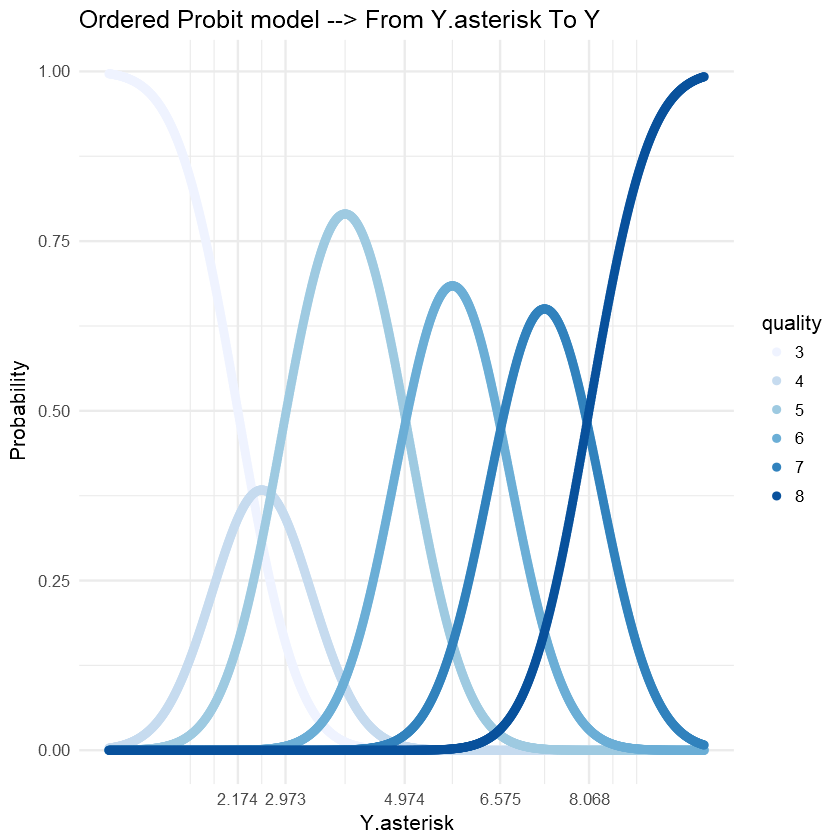

In [40]:
y_mean <- mean(m3data$quality_ima)
y_sd <- sd(m3data$quality_ima) 

y_asterisk = data.frame(seq(0.01,10,0.01))
names(y_asterisk) = "continues_Y"

y_asterisk$three = pnorm((2.1740-y_asterisk$continues_Y) / y_sd,lower.tail = TRUE)
y_asterisk$four = pnorm((2.9732-y_asterisk$continues_Y) / y_sd,lower.tail = TRUE) - 
  pnorm((2.1740-y_asterisk$continues_Y) / y_sd,lower.tail = TRUE)
y_asterisk$five = pnorm((4.9743-y_asterisk$continues_Y) / y_sd,lower.tail = TRUE) - 
  pnorm((2.9732-y_asterisk$continues_Y) / y_sd,lower.tail = TRUE)
y_asterisk$six = pnorm((6.5754-y_asterisk$continues_Y) / y_sd,lower.tail = TRUE) - 
  pnorm((4.9743-y_asterisk$continues_Y) / y_sd,lower.tail = TRUE)
y_asterisk$seven = pnorm((8.0676-y_asterisk$continues_Y) / y_sd,lower.tail = TRUE) - 
  pnorm((6.5754-y_asterisk$continues_Y) / y_sd,lower.tail = TRUE)
y_asterisk$eight = 1- pnorm((8.0676-y_asterisk$continues_Y) / y_sd,lower.tail = TRUE)
names(y_asterisk) <-c("continues_Y","3","4","5","6","7","8")

y_asterisk.long <- melt(data = y_asterisk,id.vars = "continues_Y",variable.name = "quality",value.name = "probability")

ggplot(y_asterisk.long,aes(x= continues_Y,y=probability,color = quality)) +
  geom_point() +
  scale_color_brewer(palette="Blues") +
  scale_x_continuous(breaks = c(2.174,2.973,4.974,6.575,8.068)) +
  labs(x = "Y.asterisk", y = "Probability",title ="Ordered Probit model --> From Y.asterisk To Y") 

上图就是由`traindata`得到的有序Probit模型的具体分类判断过程演示图：  
对于$Y^{\ast}$的每一个点，都会算出其3，4，5，6，7，8六个分类相对应的概率，哪个分类的概率最大就倍划分到哪个类别。

如图中当$Y^{\ast} = 5.5$时，该点的各级别的概率为：  
$$P(Y=3)=0,\,P(Y=4)=0.0007,\,P(Y=5)=0.2542,\,P(Y=6)=0.6561,\,P(Y=7)=0.0883,\,P(Y=8)=0.0007\,$$  

其中$P(Y=6)$概率最高，所以被划分为quality : 6  


# 7. 进步思考

## 7.1 分析中的困难 与启发 

### 7.1.1 ggplot画图中的宽数据向长数据的转换  

一开始在做图得到的宽数据，如画图3时数据集：  

In [41]:
head(y_asterisk)

continues_Y,3,4,5,6,7,8
0.01,0.9966562,0.003241656,0.0001021656,2.462781e-10,1.110223e-16,0
0.02,0.9965276,0.003365067,0.0001073469,2.667405e-10,1.110223e-16,0
0.03,0.9963946,0.003492657,0.0001127742,2.888586e-10,1.110223e-16,0
0.04,0.9962570,0.003624545,0.0001184582,3.127628e-10,1.110223e-16,0
0.05,0.9961147,0.003760855,0.0001244102,3.385932e-10,1.110223e-16,0
0.06,0.9959676,0.003901711,0.0001306418,3.665006e-10,1.110223e-16,0


我花了好多时间在寻找如何将这些数据放在一张图里（每个quality用一条曲线表示），但是并没有找到好办法，后面想到课程中关于宽/长数据的介绍，发现ggplot在长数据中非常轻松的作图，在用reshape2包的melt方法进行转换后，得到：

In [42]:
head(y_asterisk.long)

continues_Y,quality,probability
0.01,3,0.9966562
0.02,3,0.9965276
0.03,3,0.9963946
0.04,3,0.9962570
0.05,3,0.9961147
0.06,3,0.9959676


之后的画图就非常简单了，只要将`aes(color = factor(quality))`进行区分就得到了我需要的图形

### 7.1.2 EDA项目的启发  
  
该项目给我最重要的启发就是在数据分析前要充分的对数据的结构，单变量，双变量，甚至多个变量的关系和特征进行充分的挖掘，并通过图形来展示，表格作为辅助。看似前期的耗时增加，而其实是保证了之后分析的有效性，从而从整体看是一个非常值得去做的步骤。


## 7.2 改进思路

在数据探索中发现quality的分类虽然有(0 ~ 10)十一个分级，实际评分中只有3 ~ 8六个级别的数据，显然分级太多反而不利于评分，采用(0 ~ 10)这种分级标准有以下缺陷：  

- 由于太多分级会要求专家将主观感受进行精细划分，这点就与主观评分的原理相悖。
- 实际中只有部分评分被采用说明专家对这个太细化的评分标准的不适应，没有用到的指标不仅没有起到细化的作用，反而可能产生失真。

因此最合适的主观评分标准应是每个级别都有一定的频数，因此我认为在这里quality可以采用(0 ~ 5)六级评级标准，0为最差，5为最好。
